# Hate Speech Detector 2.0
---
**Simple Machine Learning vectorized text classifier**

1. Load lemmatized tweets.
2. Implement several vectorizers and choose one.
3. Implement simple ML vector classifiers (i.e.: DecisionTree, SVM, RandomForest, etc.). Pass chosen vectorizer class as a parameter.
4. Perform multilabel classification task.
5. Visualize results by 7 different hate-speech labels plus 1 overall confusion matrices.
6. Perform some test on independent sanitized tweets about polish courts.

In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.classifiers.SimpleMLVectorClassifier import SimpleMLVectorClassifier
from src.vectorizers.TextOwnTrainedFTVectorizer import TextOwnTrainedFTVectorizer
from src.dataframes.utils import combine_row_wisely, shuffle_dataframe
from src.visualization.classification import confusion_matrices, models_quality_plot, best_model_for_class
from src.constants import LABELS, DUPLICATED_PATH, LEMMAS_PATH

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
plt.style.use('ggplot')

## Data loading

### Classes

In [4]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Lemmatized tweets

In [5]:
df_lemmatized = pd.read_csv(LEMMAS_PATH).drop(['id'], axis=1)
df_lemmatized.head(2)

,lemmatized
0,w czwartek musieć poprawić sąd i trybunał
1,żale nałęcz i riposta macierewicz pan być w ko...


### Combined data

In [6]:
df_data = combine_row_wisely([df_lemmatized, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,lemmatized,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
9078,niech maeać czerwony sada prawo i sprawiedliwo...,1,1,1,0,1,1,0
2431,dodać być jeszcze do sąd nie mieć zdanie,0,0,0,0,0,0,0


## Models implementation and testing

In [7]:
MODEL_CLASSES = [DecisionTreeClassifier, DecisionTreeClassifier,
                 RandomForestClassifier, RandomForestClassifier,
                 SGDClassifier, SGDClassifier,
                 LogisticRegression, LogisticRegression,
                 ]
MODEL_KWARGS = [{'criterion': 'gini', 'class_weight': 'balanced'},
                {'criterion': 'entropy', 'class_weight': 'balanced'},
                {'criterion': 'gini', 'class_weight': 'balanced'},
                {'criterion': 'entropy', 'class_weight': 'balanced'},
                {'penalty': 'l1', 'class_weight': 'balanced'},
                {'penalty': 'l2', 'class_weight': 'balanced'},
                {'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'},
                {'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'},
                ]
MODEL_LABELS = ['DTC-gini', 'DTC-entropy',
                'RFC-gini', 'RFC-entropy',
                'SGD-l1', 'SGD-l2',
                'LRC-l1', 'LRC-l2',
                ]

In [8]:
X_data = df_data.drop(LABELS, axis=1).values
y_data = df_data[LABELS].values

y_preds = list([])

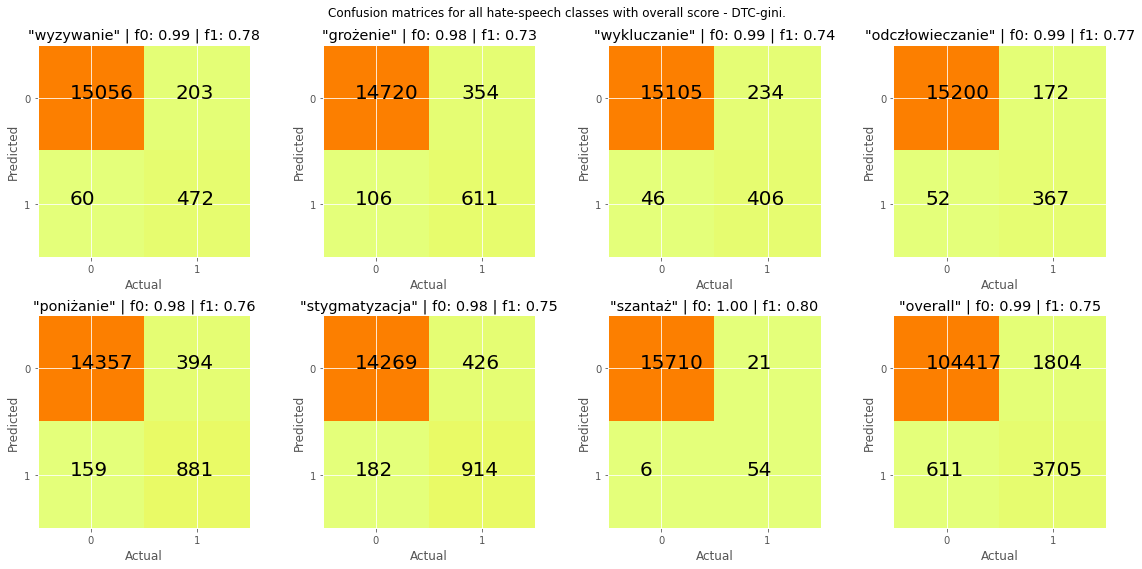

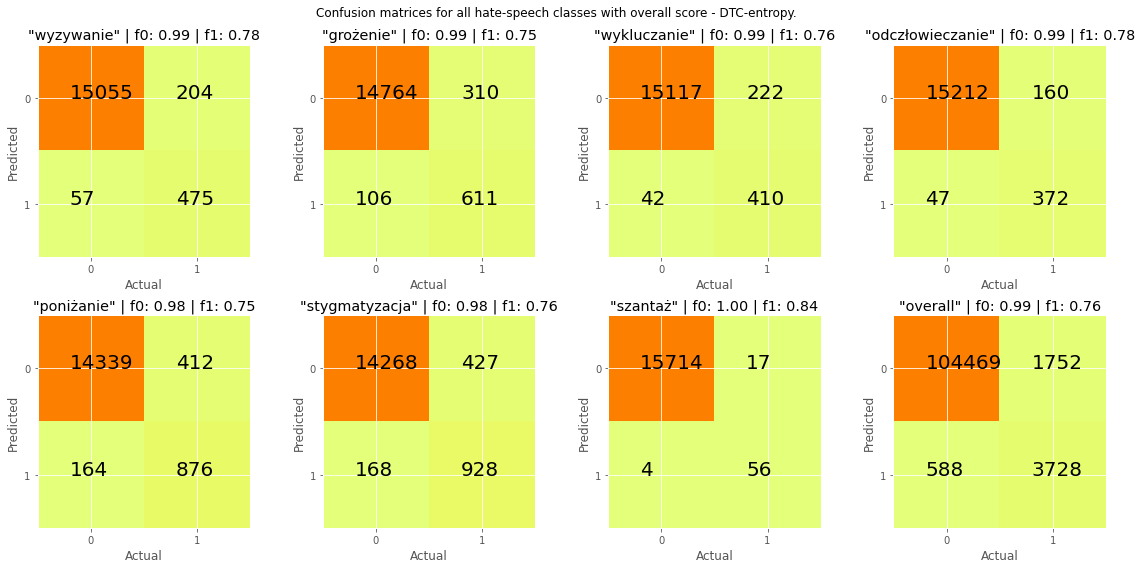

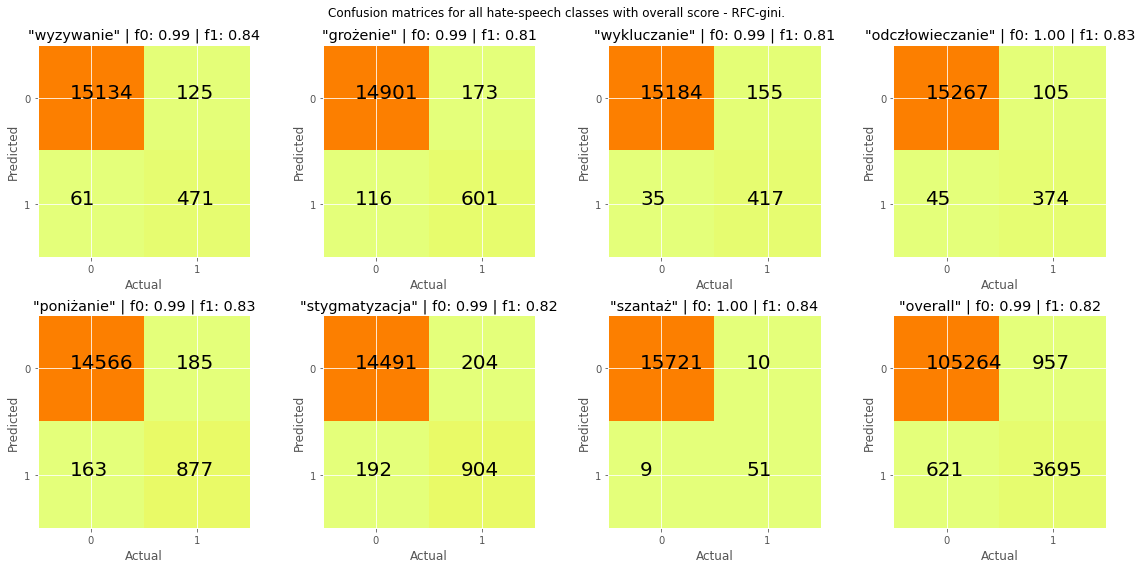

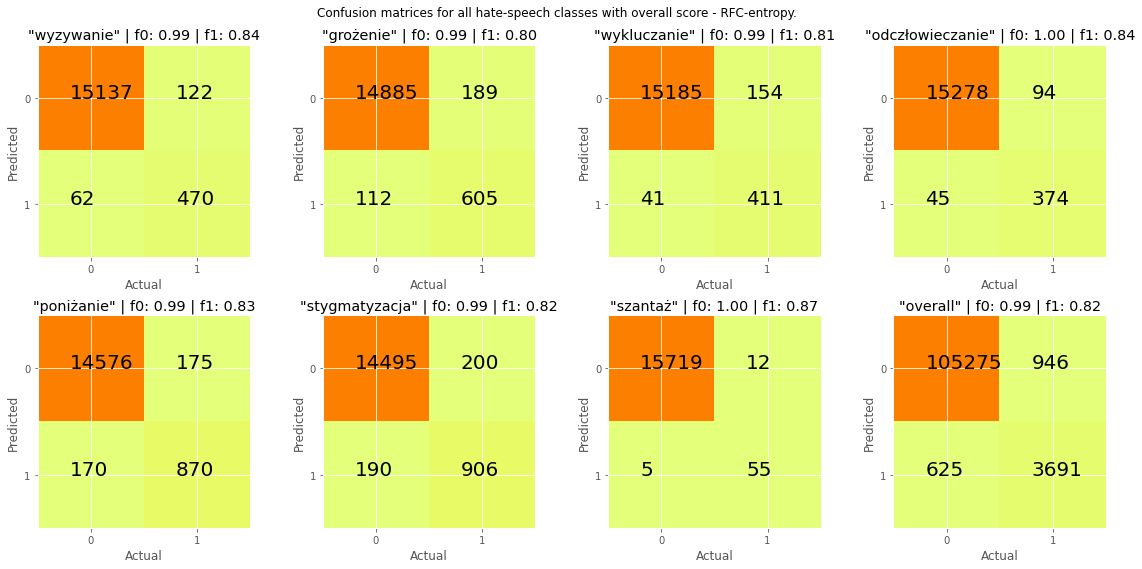

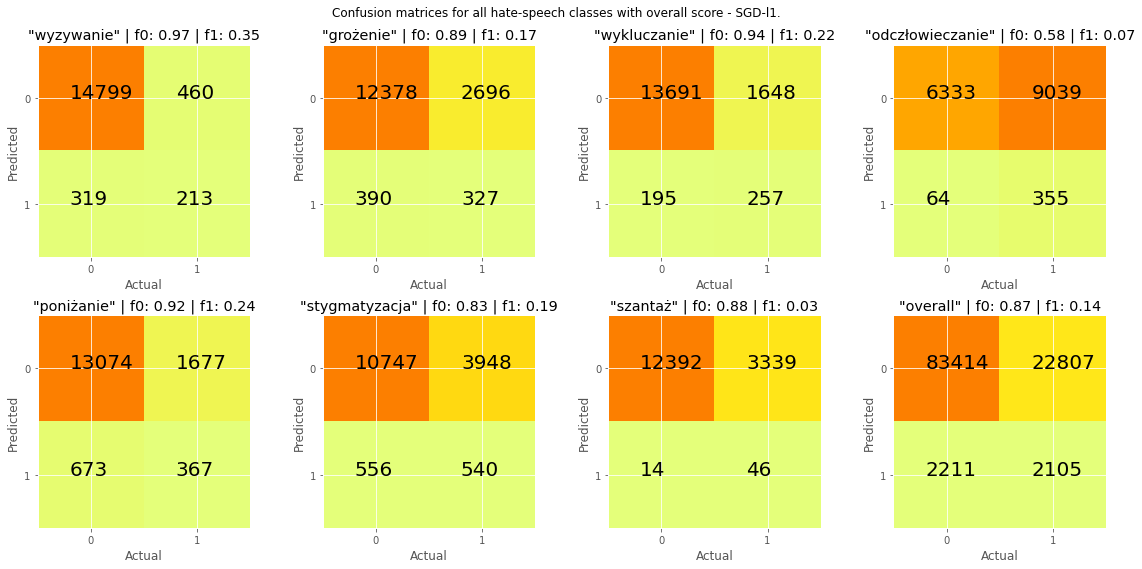

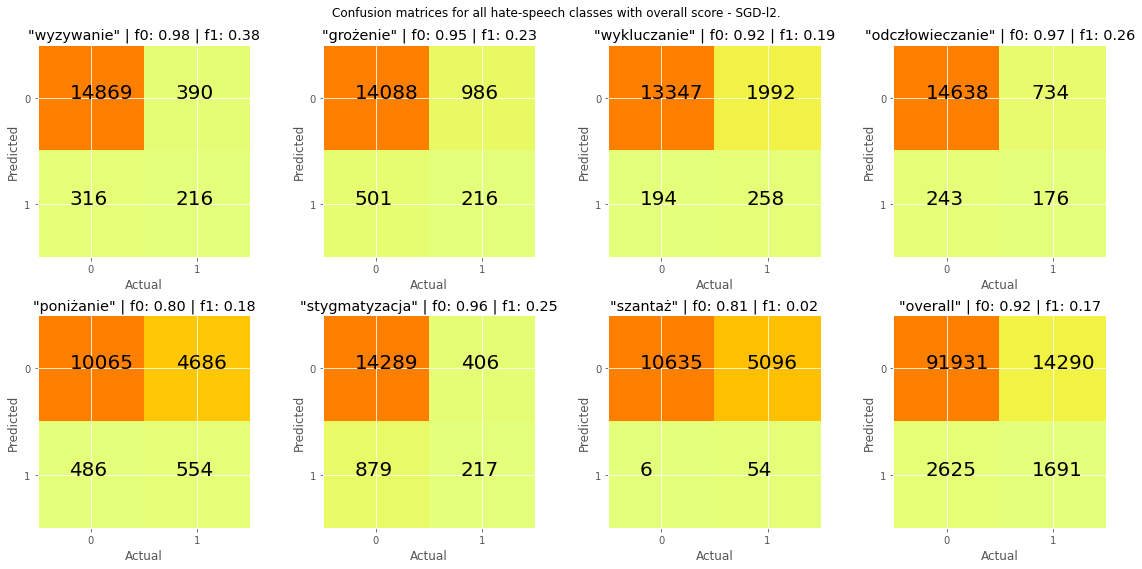

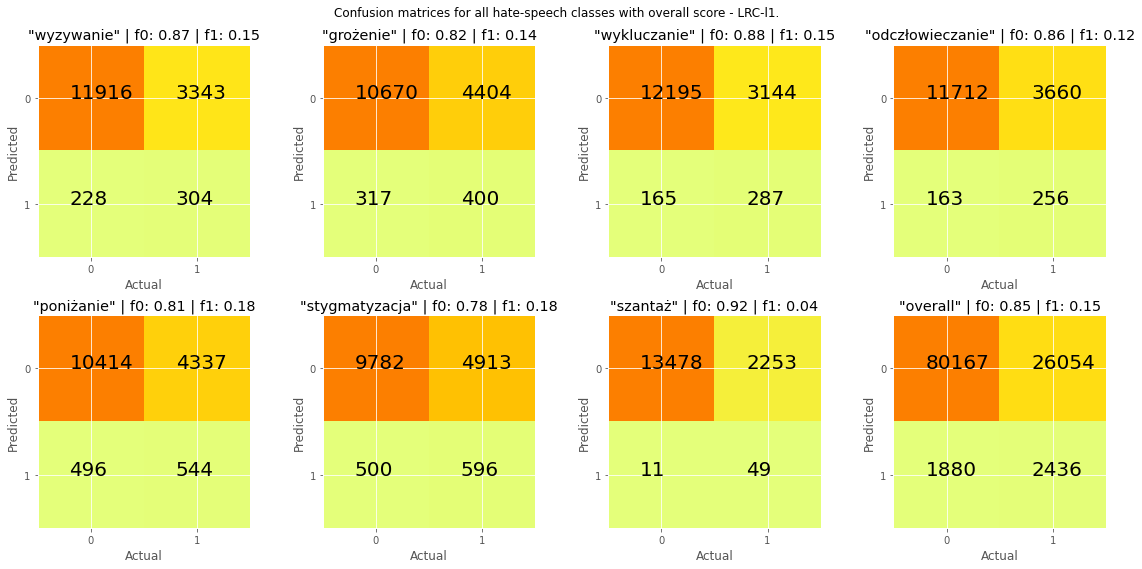

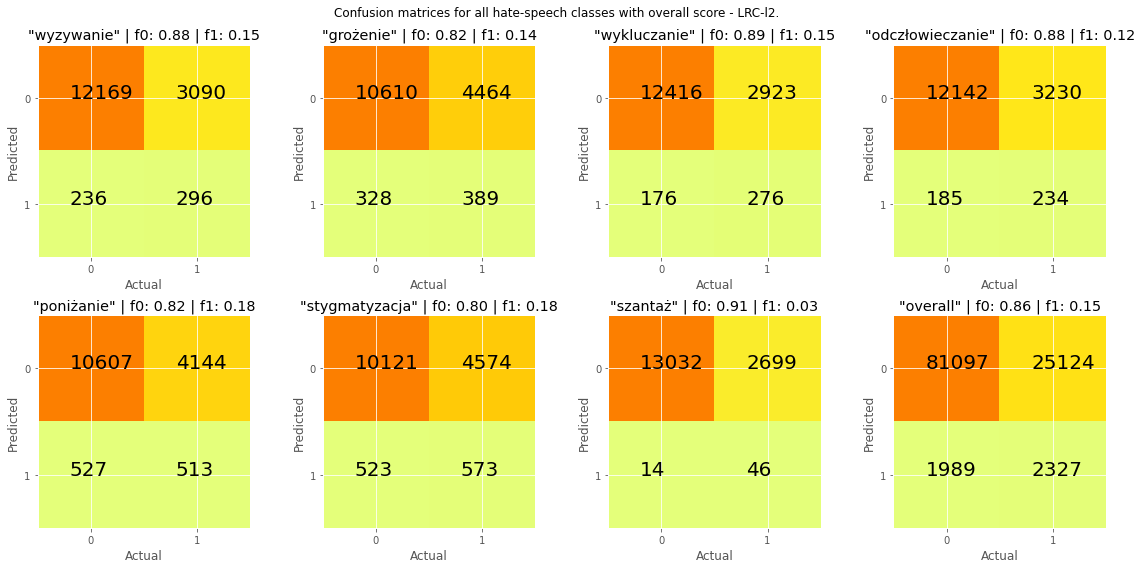

In [9]:
vkwargs = dict({'length': 300, 'model_type': 's', 'short_name': 'super', 'verbose': 0})
for mclass, mkwargs, mlabel in tqdm(zip(MODEL_CLASSES, MODEL_KWARGS, MODEL_LABELS),
                                                   total=len(MODEL_LABELS), leave=None):
    clf = SimpleMLVectorClassifier(k_folds=5, short_name=mlabel, vec_class=TextOwnTrainedFTVectorizer,
                                   clf_class=mclass, verbose=0, vec_kwargs=vkwargs, **mkwargs)
    
    clf.fit(X_data, y_data)
    # clf.load()
    clf.save()
    
    y_pred = clf.predict(X_data)
    confusion_matrices(y_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score - {mlabel}.')
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

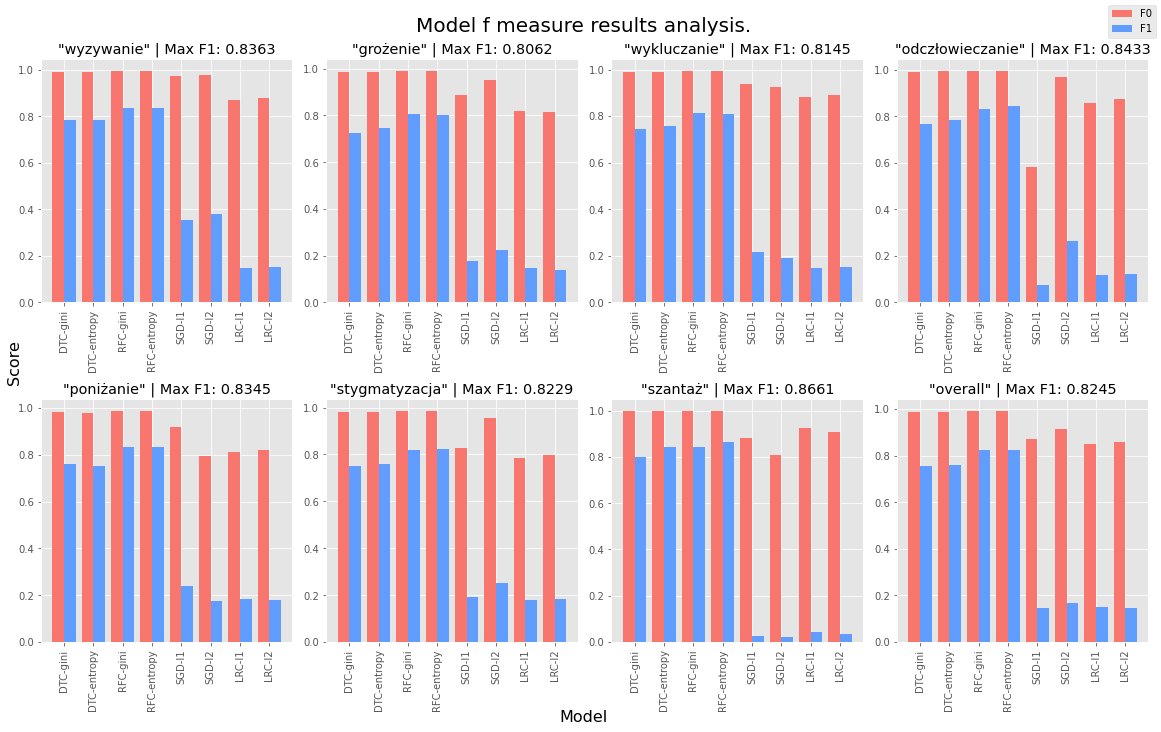

In [18]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='Model f measure results analysis.', measure='f', colors=['#f9766e', '#619dff'])

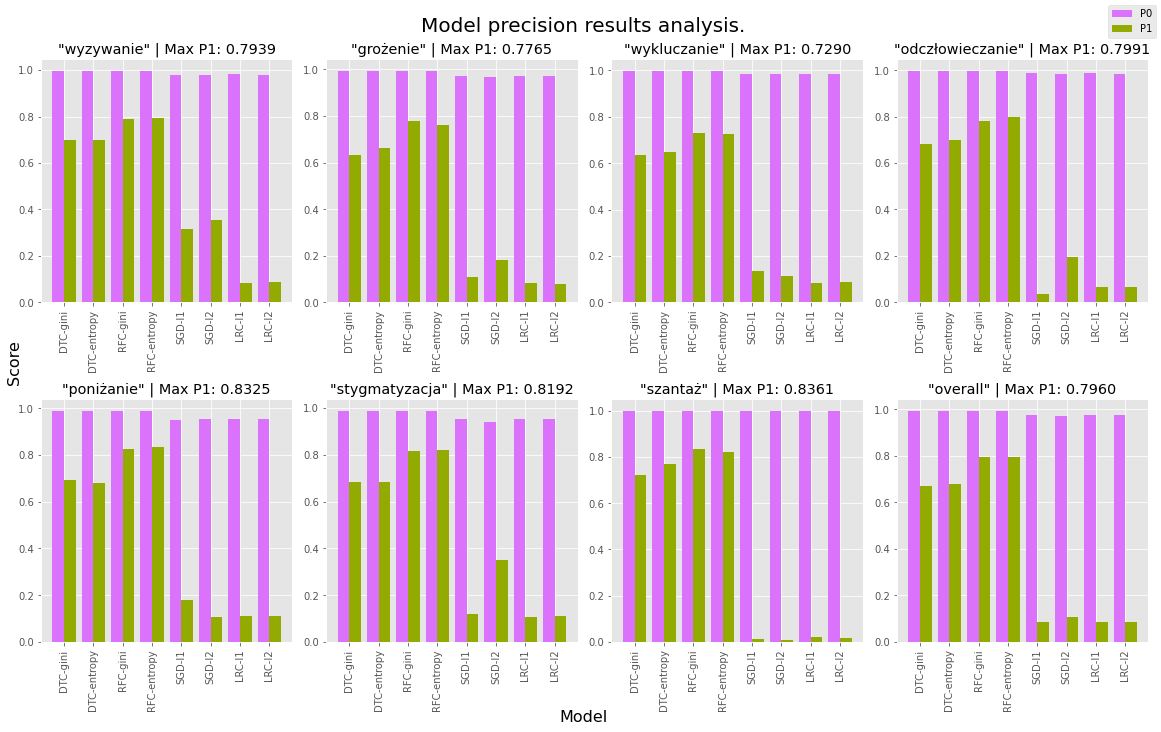

In [11]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='Model precision results analysis.', measure='p', colors=['#da72fb', '#93aa00'])

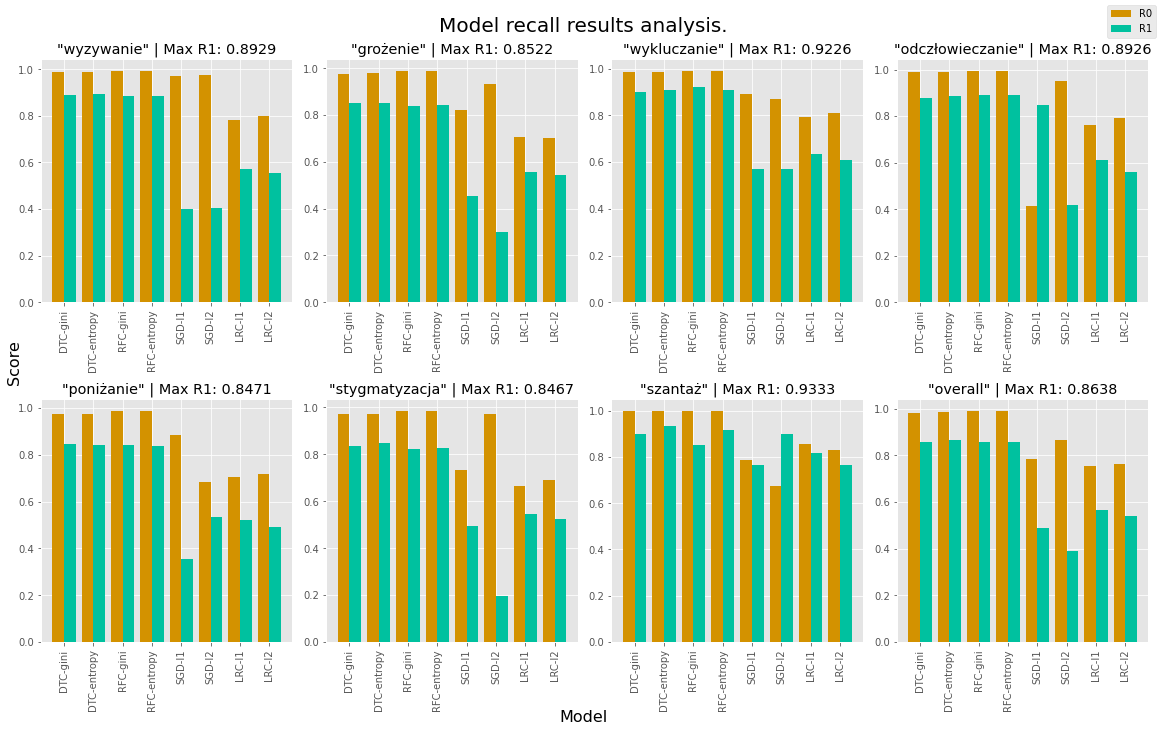

In [12]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='Model recall results analysis.', measure='r', colors=['#d39200', '#00c19f'])

## Best classifier

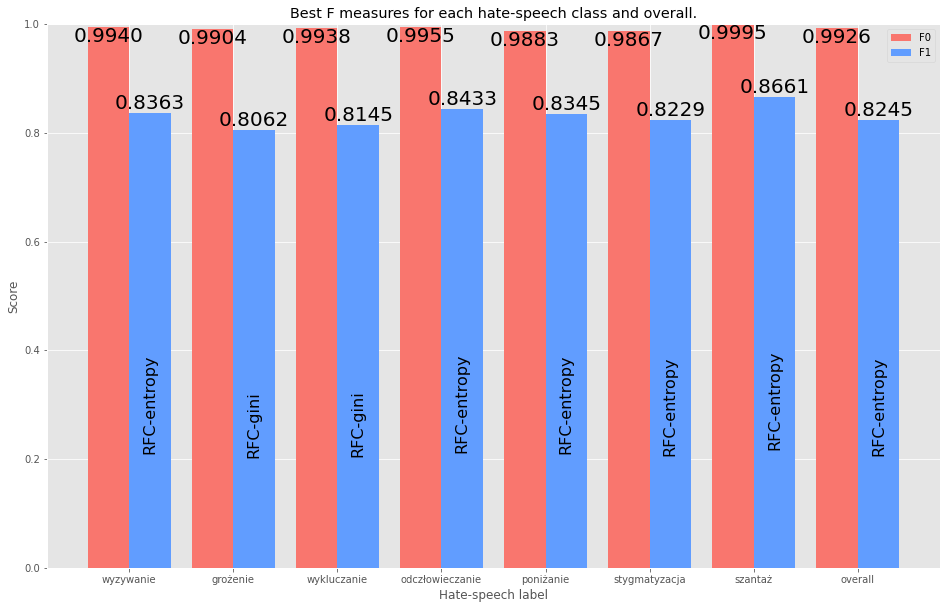

In [13]:
best_model_for_class(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS)

Judging by the above two analyses the best simple ML classifier is **RandomForest with entropy loss**.

In [14]:
vkwargs = dict({'length': 300, 'model_type': 's', 'short_name': 'super', 'verbose': 0})
clf = SimpleMLVectorClassifier(k_folds=5, short_name='RFC-entropy', vec_class=TextOwnTrainedFTVectorizer,
                               clf_class=RandomForestClassifier, vec_kwargs=vkwargs,
                               **{'criterion': 'entropy', 'class_weight': 'balanced'})
clf.load()

## Tests

### Test 1

In [15]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
preds1 = clf.test(test_text1)
dict(zip(LABELS, preds1.flatten()))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be: 'stygmatyzacja': 1.0.

### Test 2

In [16]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
preds2 = clf.test(test_text2)
dict(zip(LABELS, preds2.flatten()))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be 'grożenie', 'wykluczanie', 'poniżanie' and 'stygmatyzacja' as 1.0.

### Test 3

In [17]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
preds3 = clf.test(test_text3)
dict(zip(LABELS, preds3.flatten()))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be: 'grożenie': 1.0.